# 演習・Kerasによるプログラミング入門（5）

## ライブラリーのインポート
次のプログラムを実行して、必要なライブラリーをインポートして下さい。
```python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import japanize_matplotlib
import os
import numpy as np
import random
import pickle
```

In [4]:
pip install japanize_matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import japanize_matplotlib
import os
import numpy as np
import random
import pickle

### tensorflowをインポートできなかった場合
Google Colaboratoryではエラーは発生しない筈ですが、
「tensorflowが見つからない」というエラーが発生した場合は、
**次のプログラムを実行した後、前のプログラムを再実行**して下さい。

前のプログラムでエラーが出なかった場合は、次のプログラムを実行する必要はありません。

```python
!pip install tensorflow
```

### japanize_matplotlibをインポートできなかった場合
Google Colaboratoryでは「japanize_matplotlibが見つからない」という
エラーが発生するかも知れません。
**次のプログラムを実行した後、インポートを再実行**して下さい。

前のセルでエラーが出なかった場合は、次のプログラムを実行する必要はありません。

```python
!pip install japanize_matplotlib
```

## 転移学習
画像認識など、
高度な機能の実現には、
多くの層を含むニューラルネットを用いた**深層学習**が必要となります。

深層学習により従来は考えられなかったほど高精度の画像認識が可能となりますが、
次のような難しさがあります。

- ニューラルネットの構成によって成否が大きく変動し、
適切な構成を設計するには経験が必要となります。
- 非常に多くのハイパーパラメータを含むため、
それらを適切に設定するには経験に加えて、
試行錯誤を免れないので時間がかかります。
- 学習により最適化するパラメータの個数が非常に多くなるため、
学習に多くの訓練データが必要となります。
膨大な訓練データによる学習には、
大きな計算資源と長い学習時間が必要となります。

これらの困難性は、
一般の人々が深層ネットワークを実装することを阻害する要因になっていました。

この課題の解決として、
汎用のデータで事前に訓練したモデルの上に、
層を追加し、手許の訓練データで若干の追加学習を行う手法が開発されました。
この手法を**転移学習（transfer learning）**と呼びます。

転移学習では、
**比較的小さな計算資源と短い学習時間で大きな効果**を得ることが可能となります。

ここでは、Inception version 3というニューラルネットを、
Imagenetと呼ばれる汎用の画像データセットで学習したモデルをベースとして、
転移学習を体験しましょう。

例題として、

**オムレツ（omelette）・ピザ（pizza）・サモサ（samosa）のいずれかの画像を入力して、
画像が3種の食べ物のいずれかを識別する**

問題を考えます。

### 演習
InceptionとImageNetについてネットで調べ、
理解したことを次のセルに日本語で簡潔に記述せよ。

#### InceptionとImageNetについて調べた内容をこのセルに記述せよ

## Inception version 3とImageNet
ImageNetで学習したInception version 3を導入して、
どのようなものか見てみましょう。

```python
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet', include_top=True)
with open('imagenet_labels', 'rb') as f:
    imagenet_labels = pickle.load(f)
```

上のプログラムは、
1. Kerasに用意されているInceptionV3をインポート
1. InceptionV3のオブジェクトを生成
1. ImageNetのラベルを取得

するためのコードです。



- 引数`weights='imagenet'`により、
ImageNetの学習により最適化されたパラメータ（重みとバイアス）をセットします。

- 引数`include_top=True`により、フルセットのInceptionV3を取得します。
後述しますが、InceptionV3を転移学習に使用するときには、
引数の値をFalseにしてInceptionV3の一部のみを取得します。

- フルセットのInceptionV3は、
入力されたイメージデータを1000のラベルに分類します。
次のプログラムにより、英語によるラベルの説明文を入力します。
```python
with open('imagenet_labels', 'rb') as f:
    description = pickle.load(f)
```

> ImageNetのラベルには、次のようなものが含まれます。
> - ホオジロサメ（great white shark）、雄鶏（cock）、クラゲ（jellyfish）のような動物
> - 弓（bow）、マグカップ（coffee mug）、戦車（tank）のような人工物
> - バナナ（banana）、赤ワイン（red sine）のような飲食物
> - 珊瑚礁（coral reef）、火山（volcano）、谷（valley）のような自然物
>
> 例題で用いる3種のラベルについては、
ピザ（pizza, pizza pie）はImageNetのラベルに含まれていますが、
オムレツとサモサは含まれていません。


In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(weights='imagenet', include_top=True)
with open('imagenet_labels', 'rb') as f:
    imagenet_labels = pickle.load(f)

Inceptionを利用できるように、ニューラルネットを構成しましょう。

1. 「演習・Kerasによるプログラミング入門（1）〜（3）」で勉強したように、
```python
model = Sequential()
```
によって、初期化されたモデルを生成し、
このモデルにadd関数を使って層（ネットワーク）を追加していきます。
1. ここでは、次のコードで、Inceptionを追加します。
```python
model.add(inception)
```
1. compile関数によってニューラルネットを確定します。
1. 最後にネットワークの構成を確認してみましょう。
2400万に近い個数のパラメータ（重み・バイアスなど）を含んでいることが分かります。
膨大なパラメータを最適化するには、
大きな訓練用のデータセットと、長時間の学習が必要です。

```python
model = Sequential()
model.add(inception)
model.compile()
model.summary()
```

In [8]:
model = Sequential()
model.add(inception)
model.compile()
model.summary()

ValueError: Undefined shapes are not supported.

Inceptionにイメージを入力してラベルを予測してみましょう。

### 予測と表示のための関数

画像データを指定して、
予測結果とイメージを表示するpredict_label関数を以下のように定義します。

```python
benign_labels = {i:str(i) for i in range(1000)}
def predict_label(model, img, show=True, label=benign_labels):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    pred = model.predict(img, verbose=0)
    index = np.argmax(pred)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title("予測：" + label[index])
        plt.show()
    return index
```

| 引数 | 内容 |
| :--- | :--- |
| 第1引数 | 予測に使用するモデル |
| 第2引数 | イメージデータへのパス |
| show | 画像を表示するか否か（True、または、False） |
| label | ラベルに関する文字情報（配列、または、辞書オブジェクト）|

In [13]:
benign_labels = {i:str(i) for i in range(1000)}
def predict_label(model, img, show=True, label=benign_labels):
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    pred = model.predict(img, verbose=0)
    index = np.argmax(pred)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title("予測：" + label[index])
        plt.show()
    return index

### テストデータセット
テストデータの画像ファイルは、
food-101/test_miniフォルダの下のomelette・pizza・samosaの
各フォルダに分類して格納されています。
**データをまだセットしていない方は指示に従ってセットして下さい。**

画像データへのパスは辞書オブジェクトtest_imgsに格納します。
例えば、`test_imgs['omelette']`とすると、
オムレツが写った画像へのパスのリストが得られます。

```python
train_dir = 'food-101/train_mini'
val_dir = 'food-101/val_mini'
test_dir = 'food-101/test_mini'
food_labels = ['omelette', 'pizza', 'samosa']
test_imgs = {f:[test_dir+'/'+f+'/'+fn
                for fn in os.listdir(os.path.join(test_dir+'/'+f))]
             for f in food_labels}
```

In [ ]:
import os

In [11]:
train_dir = 'food-101/train_mini'
val_dir = 'food-101/val_mini'
test_dir = 'food-101/test_mini'
food_labels = ['omelette', 'pizza', 'samosa']
test_imgs = {f:[test_dir+'/'+f+'/'+fn
                for fn in os.listdir(os.path.join(test_dir+'/'+f))]
             for f in food_labels}

### Inceptionによる予測
準備が出来ましたので、
次のプログラムでInceptionがどのような予測をするか確認します。

- 入力画像はオムレツ・ピザ・サモサのいずれかから選びます。
- InceptionはImageNetの1000のラベルのいずれかを予測として返します。

次の点を確認して下さい。

- ピザの画像の入力に対して、常に正しく「pizza, pizza pie」を返すか？
- ImageNateにオムレツ・サモサに対応するラベルは存在しないので、
どのラベルが予測されるだろうか？

次のプログラムを実行すると、
選択した料理の画像とInceptionの予測が表示されます。
プログラムを終了するためには半角の「4」を入力して下さい。

```python
while True:
    select = int(input("0. Omelette 1. Pizza 2. Samosa 3. ランダム 4. 終了 (半角で番号を入力)"))
    if select in range(5):
        if select == 4:
            print("終了しました。")
            break
        if select == 3:
            select = random.choice(range(3))
        im = random.choice(test_imgs[food_labels[select]])
        predict_label(model, im, show=True, label=imagenet_labels)
```

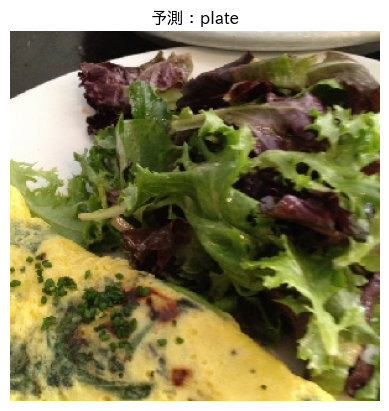

終了しました。


In [14]:
while True:
    select = int(input("0. Omelette 1. Pizza 2. Samosa 3. ランダム 4. 終了 (半角で番号を入力)"))
    if select in range(5):
        if select == 4:
            print("終了しました。")
            break
        if select == 3:
            select = random.choice(range(3))
        im = random.choice(test_imgs[food_labels[select]])
        predict_label(model, im, show=True, label=imagenet_labels)

#### ピザの画像に対する予測
次のプログラムで、ピザの画像を入力したとき、
Inceptionが正しく「pizza, pizza pie」を予測する率を計算します。

```python
pred = [predict_label(model, im, False) for im in test_imgs['pizza']]
print('予測の正解率＝', accuracy_score(pred, [963]*len(test_imgs['pizza'])))
```

In [15]:
pred = [predict_label(model, im, False) for im in test_imgs['pizza']]
print('予測の正解率＝', accuracy_score(pred, [963]*len(test_imgs['pizza'])))

予測の正解率＝ 0.952


かなり高い正解率が示されたものと思います。

画像の候補がオムレツ・ピザ・サモサの3種類に限定される時、
この正解率を改善できる可能性があります。
この可能性を検証することが、この資料の課題のひとつである。

#### オムレツの画像に対する予測
ImageNetはオムレツに対応するラベルは含まないので、
オムレツの画像を入力すると、
誤ったラベルを予測してしまいます。

どのようなラベルを予測するか、ヒストグラムで確認してみましょう。

```python
from collections import Counter
pred = [predict_label(model, im, False) for im in test_imgs['omelette']]
count = Counter(pred)
N = 10
topN = count.most_common()[:N]
x = [str(t[0]) for t in topN]
y = [t[1] for t in topN]
plt.bar(x, y)
plt.grid()
plt.xlabel('予測ラベル')
plt.ylabel('予測頻度')
plt.title('オムレツの画像に対するInceptionの予測')
plt.show()
for t in topN:
    print(t[0], imagenet_labels[t[0]], t[1])
```

In [16]:
from collections import Counter
pred = [predict_label(model, im, False) for im in test_imgs['omelette']]
count = Counter(pred)
N = 10
topN = count.most_common()[:N]
x = [str(t[0]) for t in topN]
y = [t[1] for t in topN]
plt.bar(x, y)
plt.grid()
plt.xlabel('予測ラベル')
plt.ylabel('予測頻度')
plt.title('オムレツの画像に対するInceptionの予測')
plt.show()
for t in topN:
    print(t[0], imagenet_labels[t[0]], t[1])

### 演習
サモサに対しても同様のヒストグラムを描画せよ。

# 転移学習の実際


## データジェネレータの生成
訓練のための画像データはtrain_dirで指定されたフォルダに、
テストのための画像データはtest_dirで指定されたフォルダに、
それぞれomelette、pizza、samosaを名前とするフォルダに格納されていることは既に見ました。

しかしながら、
フォルダに格納された画像データをそのままInceptionに入力できる訳ではありません。

ここでは、
訓練データをニューラルネットに入力する際に、
フォルダに格納された画像データを変形するデータジェネレータを使用します。

データの変形には、**データ成形**と**データ強化**の二つの目的があります。

### データ成形
Inceptionが受け入れられるように、データを成形する必要があります。
具体的には、以下の処理を行います。

1. 画像データはjpeg形式で記録されています。
このデータを$299 \times 299$画素のデータに変換します。
RGBの各色ごとに、色の強度を表す$299\times 299$個の整数値が指定されますので、
合計で$299\times 299\times 3$個の整数値で画像が表現されます。
1. 画素データをnumpyのndarrayに変換します。
1. Ndarrayの次元をInceptionの入力形式（`shape = (1, 299, 299, 3)`）にあわせます。
1. RGBの各色の強度は0から255までの整数値で表されていますので、
これを0から1までの浮動小数に変換します。

predict_label関数にも含まれている以下のコードにより、
上記の処理が実行されます。

```python
img = image.load_img(img, target_size=(299, 299))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img /= 255.
```

### データ強化（データオーグメンテーション）
前述のように層の数の多いネットワークを学習させるためには、
多くの訓練データが必要となりますが、
いつも十分な量の訓練データが得られるとは限りません。

そこで、画像データの場合は、
オリジナルの訓練画像を、

- 拡大・縮小する
- 回転させる
- 垂直・水平方向に反転させる、
- 斜めに歪ませる

などの方法で変形することにより、
オリジナルの画像から新しい画像データを生成して訓練に用いることを行います。

訓練データを変形させることで訓練データの嵩増しを行う処理を、
**データ強化**、とか、
**データオーグメンテーション（data augmentation）**と呼びます。

### ImageDataGenerator
次のプログラムは、
訓練データの入力にあたって、
訓練データをそのまま入力するのではなく、
データ成形とデータ強化の結果をニューラルネットに入力する
**データジェネレータ**を作成するものです。

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.keras.backend.clear_session()

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical')
```

Kerasに用意されているImageDataGeneratorクラスを使うと、
データジェネレータを簡単な設定で指定することが出来ます。

```python
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
```

例えば、上のプログラムで、
訓練データのためのデータジェネレータの原型を作ります。
- `rescale=1. / 255`：0から255までの整数値を、0から1の浮動小数に変換
- `shear_range=0.2`：斜めに歪ませる変形を20%の範囲でランダムに実行
- `zoom_range=0.2`：拡大・縮小を20%の範囲でランダムに実行
- `horizontal_flip=True`：水平方向の反転をランダムに実行

更に、
```python
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical')
```
により、画像データをパスtrain_dirから読み込み、
$299\times 299$画素のデータに変更するデータジェネレータを生成します。

> ここではバッチサイズ16のミニバッチによる学習を行います。
>
> `tf.keras.backend.clear_session()`は、
学習を繰り返し実行する際にメモリに過去のデータが蓄積することを
防止するための「おまじない」です。
`tf`は`tensorflow`をインポートする時に指定した略称です。



### InceptionV3のオブジェクト生成
転移学習のベースとなるInceptionV3のオブジェクトを生成します。

```python
inception = InceptionV3(weights='imagenet', include_top=False)
```

InceptionV3の上位層（出力に近い層）は、
1000種のラベルを予測する処理を行いますので、
転移学習の目的からは不要です。

そこで、`include_top=False`により、
上位層を除いた形でオブジェクト化します。


## ネットワークの設計と実装

「演習・Kerasによるプログラミング入門（1）〜（3）」で勉強したように、
```python
model = Sequential()
```
によって、初期化されたモデルを生成し、
このモデルにadd関数を使って層（ネットワーク）を追加していきます。

まず、Inception version 3を追加しますが、
これは次のコードで実行します。。
```python
model.add(inception)
```

Inceptionの上に
オムレツ（omelette）・ピザ（pizza）・サモサ（samosa）の3種類のラベルを識別するための
層を重ねます。

次の演習に答えることで、ニューラルネットを完成することが出来ます。

#### 演習
`model.add(inception)`に引き続いて、
以下の層を順に追加（add）して、ニューラルネットを完成させて下さい。
1. GlobalAveragePooling2D()
1. Dense(128,activation='relu')
1. Dropout(0.2)
1. Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')

「演習・Kerasによるプログラミング入門（1）〜（3）」で、
全結合層（`Dense()`）と活性化関数として利用するsoftmax関数については学びました。

これらの外に、以下の新しい種類の層が付け加えられています。

- プーリング層：GlobalAveragePooling2D()
- ドロップアウト層：Dropout(0.2)

#### 演習
プーリング層・ドロップアウト層の効用について、インターネットで調べ、
調べた内容を簡潔に記述せよ。

#### プーリング層・ドロップアウト層について調べた内容をこのセルに記述せよ。

### 学習
```python
inception = InceptionV3(weights='imagenet', include_top=False)
```
により、inceptionはImageNetにより学習済みのモデルになりますが、
新たに加えた層のパラメータ（重み・バイアス）は初期値のままですので、
学習により最適化する必要があります。

学習を行うためには、
既に学んだように、以下のステップを実行します。
1. 損失関数と最適化関数を指定して、compile関数を実行
2. 訓練データのデータジェネレータと実行エポック数を指定して、fit関数を実行。

#### ステップ1
損失関数・最適化アルゴリズム・学習率を以下のように指定します。
- 損失関数：クロスエントロピー
- 最適化アルゴリズム：確率的勾配降下法（SGD）、
- 学習率：0.0001

以下のプログラムによりコンパイルを行いますが、
上で説明していない設定については、別の機会に説明します。
ここでは「おまじない」と理解しておいて下さい。
```python
optimizer = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model.hdf5',
                               verbose=1,
                               save_best_only=True)
csv_logger = CSVLogger('history.log')
```

#### ステップ2
損失関数と最適化アルゴリズムを指定したら、
fit関数で学習を実行することができます。

```python
%%time
history = model.fit(train_generator,
                    steps_per_epoch = 2250 // 16,
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps= 750 // 16,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

with open('food_history', 'wb') as f:
    pickle.dump(history, f)
```

- 16個のデータからなるミニバッチ毎にパラメータの更新を実行するので、
1エポックあたり、
訓練データの個数2250をバッチサイズ16で割った回数だけ更新を行うことになります。
この回数を引数steps_per_epochに指定します。

- `epochs=10`により学習全体でエポックを10回まわすことを指定します。

- その他の引数については、別の資料で説明しますので、
ここでは「おまじない」と理解しておいて下さい。

学習には若干の時間がかかります。

## 予測
テストデータからランダムにデータを選んで、
モデルに予測をさせます。
オムレツ（Omelette）・ピザ（Pizza）・サモサ（Samosa）のいずれかを
撮影した画像をテストデータとして、
そのいずれが写っているかを予測します。

以下のプログラムは、
この資料の最初で「素のInception」に予測をさせた時のプログラムと殆ど同じです。
> 予測に使用するモデルとラベルの説明文とが異なります。

```python
model_best = load_model('best_model.hdf5',compile = False)
food_labels= ['omelette', 'pizza', 'samosa']

while True:
    select = int(input("0. Omelette 1. Pizza 2. Samosa 3. ランダム 4. 終了 (半角で番号を入力)"))
    if select in range(5):
        if select == 4:
            print("終了しました。")
            break
        if select == 3:
            select = random.choice(range(3))
        im = random.choice(test_imgs[food_labels[select]])
        predict_label(model_best, im, show=True, label=food_labels)
```

予測に使用するモデルは以下で指定します。

```python
model_best = load_model('best_model.hdf5',compile = False)
```

エポック数を重ねて、学習をすすめていくと、
**過適合（over fitting）**と呼ばれる現象が起こる可能性があります。

**過適合とはモデルを訓練データに過剰に適合させてしまう現象**を指します、
過適合により、
訓練データに対する予測の正解率は改善するのに対し、
テストデータや未知のデータに対する予測の正解率は却って悪化してします。

未知のデータに対する予測性能を**汎化性能**と呼びますので、
**過適合とは過剰に学習することで汎化性能が悪化する現象**
と言い換えることもできます。

仕組みについては別の資料で説明しますが、
上記のコードで生成したモデルmodel_bestは、
学習を10エポック重ねる中で、
最良の汎化性能を示したパラメータの値を指定したモデルになります。

最後に、各ラベルから50個ずつのテストデータをサンプリングして、
合計150個のテストデータに対するmodel_bestの予測の正解率を求めてみます。

```python
N = 50
samples = random.sample(test_imgs['omelette'], N)
samples += random.sample(test_imgs['pizza'], N)
samples += random.sample(test_imgs['samosa'], N)
sample_labels = [0]*N + [1]*N + [2]*N
pred = [predict_label(model_best, im, show=False) for im in samples]
print('正解率＝', accuracy_score(pred, sample_labels))
```

### 演習
ピザのテストデータをサンプリングして、
正解率を計測せよ。
素のInceptionを使った場合の正解率と比較して改善されたか？